In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
charIntIndexMapping = {s:i+1 for i,s in enumerate(chars)}
charIntIndexMapping['.'] = 0
indexToCharMapping ={i:s for s,i in charIntIndexMapping.items()}

In [5]:
#1. Build the dataset: Train, Validation and Test
block_size = 3 

def build_dataset(words):  

    block_size = 3 
    inputContext, outputCharcterForThatContext = [], []
    
    for w in words:
      
    
      contextSlidingWindow = [0] * block_size
        
      for ch in w + '.': 
        index = charIntIndexMapping[ch]
        inputContext.append(contextSlidingWindow)
        outputCharcterForThatContext.append(index)
    #print(''.join(indexToCharMapping[i] for i in context), '--->', indexToCharMapping[ix])
        contextSlidingWindow = contextSlidingWindow[1:] + [index]

    inputContext = torch.tensor(inputContext)
    outputCharcterForThatContext = torch.tensor(outputCharcterForThatContext)
    print(inputContext.shape,outputCharcterForThatContext.shape)
    return inputContext,outputCharcterForThatContext

import random
random.seed(42)
random.shuffle(words)
noOfWordForTraining = int(0.8*len(words))
noOfWordsForValidation = int(0.9*len(words))

inputContextTrain, outputCharacterTrain = build_dataset(words[:noOfWordForTraining])
inputContextValidation, outputCharacterValidation = build_dataset(words[noOfWordForTraining:noOfWordsForValidation])
inputContextTesting, outputCharacterTesting = build_dataset(words[noOfWordsForValidation:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#2. MLP revisited: Creating Parameters for MLP(Charembedding, Weights and biases)

n_embd = 2 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP(1st layer)
vocab_size=27 #unique characters we have including '.'

g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g,requires_grad=True)
biasLayer1 = torch.randn(n_hidden,generator=g,requires_grad=True)
weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g,requires_grad=True)
biasLayer2 = torch.randn(vocab_size,generator=g,requires_grad=True)

parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

10281


In [7]:
#3. Training the model
max_steps=200000
batch_size=32
lossi = []
stepsi = []
noOfColAfterFlattening = block_size*n_embd
for i in range(max_steps):
    noOfWindowsToBeUsedPerLearningStep = batch_size
    randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad 
    #track stats    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') #logging the loss in every 10,000 learning steps 
    lossi.append(loss.item())
    stepsi.append(i)

   

print("loss on training data set",loss.item())

      0/ 200000: 20.6484
  10000/ 200000: 2.4881
  20000/ 200000: 3.0926
  30000/ 200000: 2.8106
  40000/ 200000: 3.0985
  50000/ 200000: 2.0041
  60000/ 200000: 2.5635
  70000/ 200000: 2.3901
  80000/ 200000: 2.9660
  90000/ 200000: 2.5537
 100000/ 200000: 2.4078
 110000/ 200000: 2.3228
 120000/ 200000: 2.4344
 130000/ 200000: 2.1707
 140000/ 200000: 2.5956
 150000/ 200000: 1.8785
 160000/ 200000: 2.4912
 170000/ 200000: 2.0221
 180000/ 200000: 2.6983
 190000/ 200000: 1.9734
loss on training data set 2.288902997970581


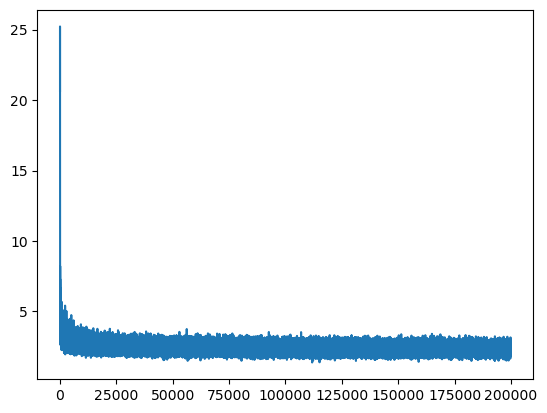

In [8]:
plt.plot(stepsi,lossi)

In [9]:
def trainingModel(inputContextTrain,charEmbeddings,weightLayer1,biasLayer1,weightLayer2,biasLayer2):
    max_steps=200000
    batch_size=32
    lossi = []
    stepsi = []
    parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
    noOfColAfterFlattening = block_size*n_embd
    for i in range(max_steps):
        noOfWindowsToBeUsedPerLearningStep = batch_size
        randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
        inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
        inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
        h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
        logits = h@weightLayer2+biasLayer2
        loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
        for p in parameters:
            p.grad = None 
        loss.backward()
        lr = 0.1 if i<100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad 
        #track stats    
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') #logging the loss in every 10,000 learning steps 
        lossi.append(loss.item())
        stepsi.append(i)
    
       
    plt.plot(stepsi,lossi)
    print("loss on training data set",loss.item())

      0/ 200000: 3.2573
  10000/ 200000: 1.9375
  20000/ 200000: 2.2970
  30000/ 200000: 2.7506
  40000/ 200000: 2.3514
  50000/ 200000: 2.1472
  60000/ 200000: 2.4106
  70000/ 200000: 2.1510
  80000/ 200000: 2.4235
  90000/ 200000: 2.0513
 100000/ 200000: 2.1214
 110000/ 200000: 2.1279
 120000/ 200000: 2.8332
 130000/ 200000: 1.9229
 140000/ 200000: 2.0449
 150000/ 200000: 1.9333
 160000/ 200000: 2.1514
 170000/ 200000: 2.2676
 180000/ 200000: 2.1108
 190000/ 200000: 2.0550
loss on training data set 1.9120447635650635


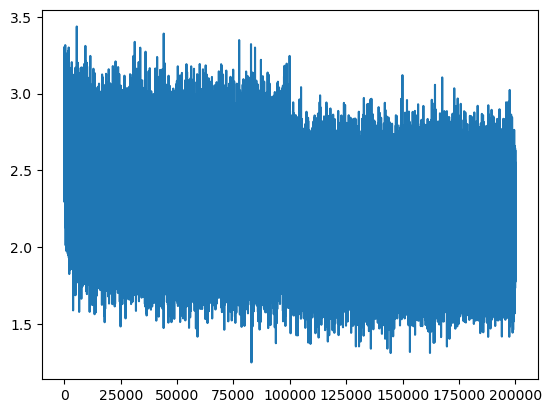

In [10]:
#4 PROBLEM-1 WITH OUR MODEL(FIXING THE INITIAL LOSS)

#1.LOSS BEFORE FIRST LEARNING STEP IS TOO HIGH
    #a. For the first learning step the loss is too high i.e 27.49, as seen from graph in next leanring steps it goes down drastically which
    #suggests that something is wrong with our parameters with which we start with

    #b. so we have 27 character possible for any place and in starting when our model is not trained every character should 
    #be equally likely so prob for any character to come at a place is 1/27 and we do negative log likelihood which is 3.29
    # and since loss is basically mean so our loss to start with is 3.29 and not 27.49 this suggests something is wrong
    #with our model to params with which we start with

#2. SOLUTION:(LOGITS is before counts step i.e the step where we do exponentiation for representing count)
    #a. We want for the first learning step logits to have value closer to each other the more wide i.e different the logit value are
    #the less equilikely will be prob of occurences and hence the more will be loss (i.e more bigger than 3.29 loss which is for equilikely)
    #b. We want logits[i][j] to have equal like values, so we want logits[i][j] to have value closer to 0
    #c. We make b2(bias for layer-2) to be 0 start with Weights for layer to be multiplied by 0.1
    #d. We dont want to multiply weights with 0, multiplying bias with 0 is fine


g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g,requires_grad=True)
biasLayer1 = torch.randn(n_hidden,generator=g,requires_grad=True)
weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g)*0.01
biasLayer2 = torch.randn(vocab_size,generator=g)*0

weightLayer2.requires_grad=True
biasLayer2.requires_grad=True

#weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g, required_grad=True)*0.1 was causing error when we were multiplyinh
#learning rate with gradient, Error was cant multiply none with fload hence separated out requires_grad=true in separate line

parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
trainingModel(inputContextTrain,charEmbeddings,weightLayer1,biasLayer1,weightLayer2,biasLayer2)


#3. Observations from Solution:
    #1. Loss for first step drastically reduces from very big value like 27 to 3.25 which we want, because equilikely prob=3.29
    #2. The plot of loss is no more hockey shape, earlier we had hockey stick like shape where we start with very high loss and
    # immediately go to lower loss, now we have fixed that issue so we have removed easy gains from our model 
    #3. Since we start with better model, we dont have to waste initial learning steps to get that easy gain which results in lesser loss
    # in model of 1.91 incomparison to previous training where we have not multiplied with 0.01 and 0

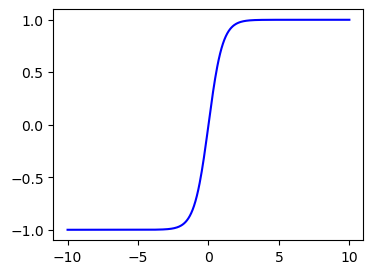

In [23]:
import numpy as np
x = np.linspace(-10, 10, 400)
y = np.tanh(x)
plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)', color='blue')

In [ ]:
#5. PROBLEM-2 WITH OUR MODEL(FIXING SATURATED tanh)
    #1. We do  h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1), we squash the result of layer-1 to a range of -1 to 1 
    # from the plot of tanh we see for value big enough like more than 3 or less than -3 tanh() gives value equal to +1 and -1 
    #respectively
    
    #2. Gradient for these portions in tanh graph is zero because graph is flat for x>+3 and x<-3
    
    #3.When we do gradient decent in backward pass the impact of those cells of matrix resulting from 
    #h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1) whose value is big enough will not be optimised because their 
    #gradient is zero, Suppose if entire column of matrix h is 1 or -1 then that neuron's weight can never be optimised and
    #it will be a dead neuron
    
    #4 Sometimes having very large learning rate also results in dead neuron problem

#SOLUTION: 
#1. Mutiply bias and weight for the layer where we are using tanh as activation with very small number like 0.01 so
# value from matrix multiplication is very small
#2. We multiply bias of layer-1 with 0.01 and weight of layer-1 with 0.2








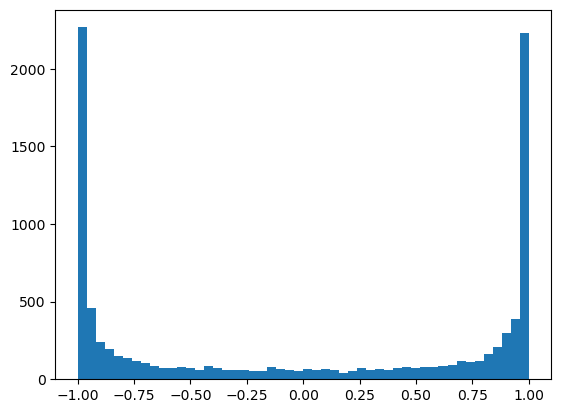

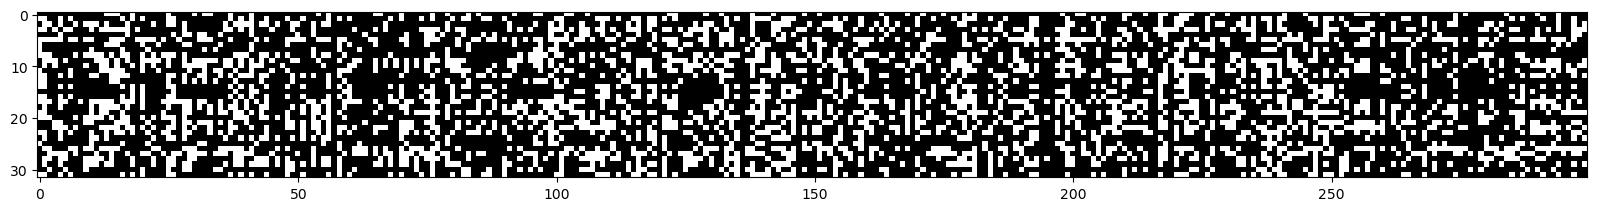

In [59]:
#5.2 Continued: PRINTING H matrix BEFORE OPTIMIZATION
g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
biasLayer1 = torch.randn(n_hidden,generator=g) 


#Printing the  tanh matrix we get from first layer output from first learning step
noOfWindowsToBeUsedPerLearningStep = batch_size
randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)

plt.hist(h.view(-1).tolist(),50) #50 represents number of intervals we want to distribute data into

plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

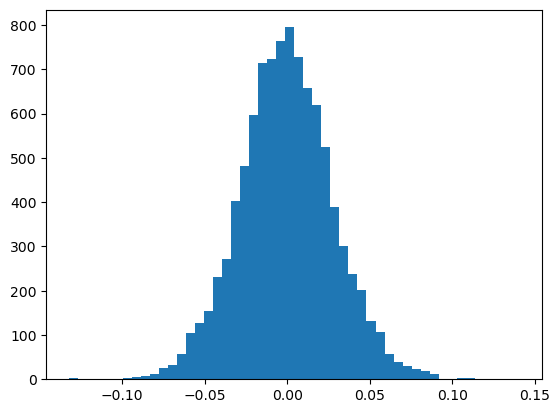

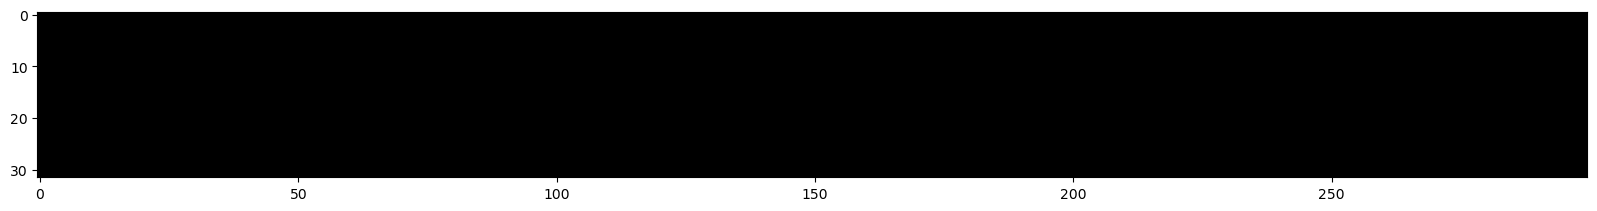

In [61]:
#5.3 Continued: PRINTING H matrix AFTER OPTIMIZATION
g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*0.01 
biasLayer1 = torch.randn(n_hidden,generator=g)*0.01 


#Printing the  tanh matrix we get from first layer output from first learning step
noOfWindowsToBeUsedPerLearningStep = batch_size
randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)

plt.hist(h.view(-1).tolist(),50)

#OBSERVATIONS: 
#From PLOT-1(Blue histogram):
    #We have quite brough value of tanh in range less than -1 and 1, no cell in matrix have value =1 or -1
    #this results in no cell have 0 gradient


plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

#OBSERVATIONS-2:
#FROM PLOT-2(Bar code like matrix)
    #1. Barcode is matrix we get from layer-1 after tanh activation function, cell have gray color if h[i][j]>abs(0.99)
    #2. So all the cells which have which have white/gray color in the matrix have absolute value>0.99 which means they 
        #can contribute to zero gradient
    #3. If full column is white then that means we have that neuron (represented by that col) as dead neuron
    #We can see without optimization as well we didnot have problem of dead neuron atleast!!!!


      0/ 200000: 3.2953
  10000/ 200000: 2.3034
  20000/ 200000: 2.1668
  30000/ 200000: 1.9077
  40000/ 200000: 2.4309
  50000/ 200000: 2.5877
  60000/ 200000: 2.2163
  70000/ 200000: 2.1314
  80000/ 200000: 2.5812
  90000/ 200000: 2.4483
 100000/ 200000: 2.4543
 110000/ 200000: 1.7064
 120000/ 200000: 2.3494
 130000/ 200000: 1.7856
 140000/ 200000: 2.1673
 150000/ 200000: 2.5221
 160000/ 200000: 2.1953
 170000/ 200000: 2.3498
 180000/ 200000: 2.2333
 190000/ 200000: 2.2908
loss on training data set 1.9592854976654053


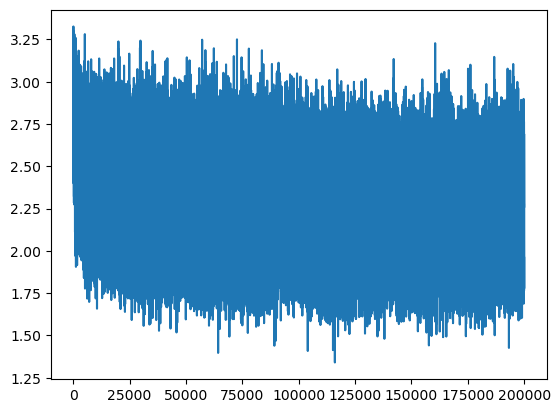

In [45]:
#5.4 Continued Training the model on train set(after solving problem-2)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*0.2
biasLayer1 = torch.randn(n_hidden,generator=g)*0.01
weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g)*0.01
biasLayer2 = torch.randn(vocab_size,generator=g)*0

weightLayer2.requires_grad=True
biasLayer2.requires_grad=True
weightLayer1.requires_grad=True
biasLayer1.requires_grad=True

parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
trainingModel(inputContextTrain,charEmbeddings,weightLayer1,biasLayer1,weightLayer2,biasLayer2)

#OBSERVATION-2 Not much improvement in result probably because there might be lots of cell in the h matrix( the tanh matrix got
#from activation layer after layer-1) with big values causing +1 and -1 but whole column of tanh matrix were not having +1 or -1 value 
#i.e we didnot have dead neuron problem, this is can be seen from 5.2 observation-2 